<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import graphviz
import pandas as pd
import numpy as np
import random
import math
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# Some functions to plot our points and draw the models
def plot_points(features, labels, size_of_points=100):
    X = np.array(features)
    y = np.array(labels)
    spam = X[np.argwhere(y==1)]
    ham = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in spam],
                [s[0][1] for s in spam],
                s = size_of_points,
                color = 'cyan',
                edgecolor = 'k',
                marker = '^')
    plt.scatter([s[0][0] for s in ham],
                [s[0][1] for s in ham],
                s = size_of_points,
                color = 'red',
                edgecolor = 'k',
                marker = 's')
    #plt.xlabel('GRE')
    #plt.ylabel('TOEFL')
    #plt.legend(['Admitted','Not admitted'])

def plot_model(X, y, model, size_of_points=100):
    X = np.array(X)
    y = np.array(y)
    plot_step = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))
    plt.contour(xx, yy, Z,colors = 'k',linewidths = 1)
    plot_points(X, y, size_of_points)
    plt.show()

def plot_regressor(model, features, labels):
    x = np.linspace(0,85,1000)
    plt.scatter(features, labels)
    plt.plot(x, model.predict(x.reshape([-1,1])))
    plt.xlabel("Age")
    plt.ylabel("Days per week")
    plt.show()


# Native Bayes Model

it's an important ML model used in classification. It's called 'naive' because we make some assumption to simplify the calculation.

It is based on the premise that the more information we gather about an event, the better estimate of the probability we can make. Bayes' theorem answers "what is the prob of Y given X occured?" - *conditional probability*.

* **prior** - the initial probability
* **event** - something that occurs which gives us information
* **posterior** - the final (and more accurate) probability calculated using prior probability and event.

Example:
* Prior: probability that the patient is sick (1/10,000)
* Event: the patient tested positive
* Posterior: probability that the patient is sick given that he is tested positive (99/(99+9999)=0.98%)

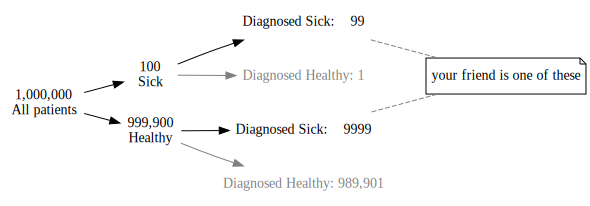

In [ ]:
import graphviz

# Create a new Digraph
dot = graphviz.Digraph(format='svg', graph_attr={'rankdir': 'LR'})

# Add nodes (parent and children)
dot.node('A', '1,000,000\nAll patients', shape='plaintext')
dot.node('S', '100\nSick', shape='plaintext')
dot.node('H', '999,900\nHealthy', shape='plaintext')
dot.node('SDS', 'Diagnosed Sick:    99', shape='plaintext')
dot.node('SDH', 'Diagnosed Healthy: 1', shape='plaintext', fontcolor='grey')
dot.node('HDS', 'Diagnosed Sick:    9999', shape='plaintext')
dot.node('HDH', 'Diagnosed Healthy: 989,901', shape='plaintext', fontcolor='grey')

# Add edges (connections)
dot.edge('A', 'S')
dot.edge('A', 'H')
dot.edge('S', 'SDS')
dot.edge('S', 'SDH', color='grey')
dot.edge('H', 'HDS')
dot.edge('H', 'HDH', color='grey')

dot.node('F', 'your friend is one of these', shape='note')
dot.edge('SDS', 'F', style='dashed', color='grey', arrowhead='none')
dot.edge('HDS', 'F', style='dashed', color='grey', arrowhead='none')
# Display the diagram
dot

In [ ]:
99/(99+9999)  # prob of friend is sick

0.00980392156862745

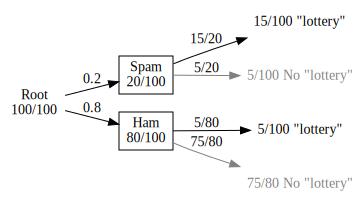

In [ ]:
# the spam email example
g = graphviz.Digraph(format='svg', graph_attr={'rankdir': 'LR'})
g.node('R', 'Root\n100/100', shape='plaintext')
g.node('S', 'Spam\n20/100', shape='box')
g.node('H', 'Ham\n80/100', shape='box')
g.node('SL', '15/100 "lottery"', shape='plaintext')
g.node('SNL', '5/100 No "lottery"', shape='plaintext', fontcolor='grey')
g.node('HL', '5/100 "lottery"', shape='plaintext')
g.node('HNL', '75/80 No "lottery"', shape='plaintext', fontcolor='grey')

g.edge('R', 'S', label='0.2'); g.edge('R', 'H', label='0.8')
g.edge('S', 'SL', label='15/20'); g.edge('S', 'SNL', label='5/20', color='grey')
g.edge('H', 'HL', label='5/80'); g.edge('H', 'HNL', label='75/80', color='grey')

g

After eliminating the tree nodes with 'No "lottery"', we calculate the probability that an email is spam given that it contains the word 'lottery' is 15/20=0.75

**Question**: what is the prob that an email that contains the word 'lottery' is spam?

**Rule of complementary probabilities**: For an event E, the complement of event E (denoted $E^c$) is the event opposite to E. The prob of $E^c$ is 1 minus the prob of E:
$$P(E^c)=1-P(E)$$

as an example, P(spam)=20%, P(ham)=1-P(spam)=80%

another example: The prob that a spam email contains 'lottery' is 15/20=0.75. This can be read as: the prob that an email contains 'lottery' given that it's a spam, is 0.75.
* $P('lottery'|spam)=0.75$ : the probability that a spam email contains the word *lottery*
* $P(no 'lottery'|spam)=1-0.75=0.25$ : the probability that a spam email does not contain the word *lottery*.
* $P('lottery'|ham)=\frac{5}{80}=0.0625$ : the probability that a ham email contains the word *lottery*
* $P(no 'lottery'|ham)=1-0.0625=0.9375$ : the probability that a ham email contains the word *lottery*

**Product rule of probabilities** For events E and F, the probability of their intersection is the product of the conditional probability of F given E, times the probability of F, namely,
$$P(E \cap F) = P(E | F) \cap P(F)$$


i.e. we find the probs of 2 events happening at the same time by multiplying the two probs:
1. $P('lottery' \cap spam)=P(spam)\cap P('lottery'|spam)=0.2 \times 0.75 = 0.15$ : The probability that *and* email is spam and contains the word lottery
2. $P(no 'lottery' \cap spam)=P(no 'lottery'|spam)\cap P(spam)=0.25\times 0.2=0.05$ : The probability that *and* email is spam and does not contain the word lottery
3. $P('lottery' \cap ham) = P('lottery'|ham) \cap P(ham)=0.0625\times0.8=0.05$ : The probability that *and* email is ham and contains the word lottery
4. $P(no 'lottery' \cap ham)=P(no 'lottery'|ham)\cap P(ham)=0.9375\times0.8=0.75$ : The probability that *and* email is ham and does not contain the word lottery

The sum of above 4 probs is 1 because they are all the possible scenarios.

Now we want to find $P(spam|'lottery')=?$, i.e. prob that email is spam, given that it contains the word 'lottery'.

From above list, there are 2 scenarios that contain the word 'lottery': $P('lottery' \cap spam)$ and $P('lottery' \cap ham)$, i.e. we only need to consider these 2 branches of the tree. The ratio between the 2 scenarios is 3:1 and they should add up to 1 (because our whole population is emails with 'lottery' only). So
* $P(spam|'lottery')=\frac{P('lottery'\cap spam)}{P('lottery'\cap spam)+P('lottery'\cap ham)}=\frac{0.15}{0.15+0.05}=3/4=0.75$
* $P(ham|'lottery')=\frac{P('lottery'\cap ham)}{P('lottery'\cap ham)+P('lottery'\cap spam)}=\frac{0.05}{0.05+0.15}=1/4=.25$

**Bayes theorum** for events E and F
$$P(E|F)=\frac{P(F|E)\cdot P(E)}{P(F)}
$$
Because event F can be broken down to 2 disjoint events $F|E$ and $F|E^c$, then
$$P(E|F)=\frac{P(F|E)\cdot P(E)}{P(F|E)\cdot P(E)+P(F|E^c)\cdot P(E^c)}
$$

Using Bayes theorum to find P(spam|'lottery'):

$P(spam|'lottery')=\frac{P('lottery'|spam)\cdot P('lottery')}{P('lottery'|spam)\cdot P(spam)+P('lottery'|ham)\cdot P(ham)}
= \frac{0.75\times (\frac{15}{100}+\frac{5}{100})}{0.75\times 0.2+0.0625\times 0.8} = \frac{0.75\times 0.2}{0.75\times 0.2+0.0625\times 0.8} = \frac{0.15}{0.15+0.05} = 0.75
$

## Two events

The above looks at single word 'lottery' in email, What about two words, i.e. two events?

If two events are independent, then the prob of both of them occuring is the product of their probs. But some cases the events are not independent - e.g. gender, eye color, but we can assume they are, hence *naive* Bayes...

**product rule for independent probabilities**:
$$P(E\cap F) = P(E)\cdot P(F)
$$

**naiive assumption**: the two events E and F are independent. Sometimes this assumption is not true - e.g. words 'salt' and 'pepper' appear in the same email...

In [2]:
# example, let's say the stats for the word 'sale' in emails are:
# P('sale'|spam) = 6/20; P('sale'|ham)=4/80
P_sale_spam = 6/20
P_sale_ham = 4/80
# from previous example we know
P_lottery_spam = 15/20
P_lottery_ham = 5/80

# calc P('lottery', 'sale' | spam)
# i.e. prob of a spam email containing both words
P_2_spam = P_lottery_spam * P_sale_spam
print("P('lotter', 'sale'|spam)=", P_2_spam)

# calc P('lottery', 'sale'|ham)
# i.e. prob of a ham email containing both words
P_2_ham = P_lottery_ham * P_sale_ham
print("P('lottery', 'sale'|ham)=", P_2_ham)

P('lotter', 'sale'|spam)= 0.22499999999999998
P('lottery', 'sale'|ham)= 0.003125


In [4]:
# if we restrict our population to emails containg both words only, i.e.
population = 20 * P_2_spam + 80 * P_2_ham
print("number emails containing both words: ", population)

# and calculate prob of spam in this population, i.e. P(spam|lottery AND sale)
P_spam_2 = 20 * P_2_spam / population
print("P(spam | lottery \cap sale)=", P_spam_2)

number emails containing both words:  4.75
P(spam | lottery \cap sale)= 0.9473684210526315


## Multiple events

Extend the above to multiple events: e.g. the email has n words x1, x2, ... xn, Bayes' theorom states that the prob of an email being spam given that it contains words x1, x2, ... xn is (comma is used the same as $\cap$:
$$P(spam|x_1, x_2, \ldots, x_n) = \frac{P(x_1, x_2, \ldots, x_n|spam)P(spam)}{P(x_1, x_2, \ldots, x_n|spam)P(spam)+P(x_1, x_2, \ldots, x_n|ham)P(ham)}
$$
Assuming all words are independent, we get

$P(x_1, x_2, \ldots, x_n|spam) = P(x_1|spam)\cdot P(x_2|spam) \ldots P(x_n|spam)$

and

$P(x_1, x_2, \ldots, x_n|ham) = P(x_1|ham)\cdot P(x_2|ham) \ldots P(x_n|ham)$

substitute them into the first equation:
$$P(spam|x_1, x_2, \ldots, x_n) = \frac{P(x_1|spam)\cdot P(x_2|spam) \ldots P(x_n|spam)P(spam)}{P(x_1|spam)\cdot P(x_2|spam) \ldots P(x_n|spam)P(spam)+P(x_1|ham)\cdot P(x_2|ham) \ldots P(x_n|ham)P(ham)}
$$


## Spam detection example

In [5]:
!rm -f data/emails.csv
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_08_Naive_Bayes/emails.csv
!ls -al data
!wc -l data/emails.csv

2025-02-24 23:43:30 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_08_Naive_Bayes/emails.csv [8954755/8954755] -> "data/emails.csv" [1]
total 8756
drwxr-xr-x 2 root root    4096 Feb 24 23:43 .
drwxr-xr-x 1 root root    4096 Feb 24 23:43 ..
-rw-r--r-- 1 root root 8954755 Feb 24 23:43 emails.csv
5729 data/emails.csv


In [24]:
emails = pd.read_csv('data/emails.csv')
emails.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [13]:
# preprocess data
def process_email(text): # text is individual email record
  text = text.lower()
  return list(set(text.split())) # return list of unique words

text = process_email(emails["text"][0])
len(text), text[:10]

(139,
 ['more',
  'its',
  'are',
  'for',
  'iogo',
  'at',
  'ciear',
  'promptness',
  'gaps',
  'website'])

In [15]:
# add another column in dataframe to store the list of unique words
emails['words'] = emails['text'].apply(process_email)

# finding the priors
sum(emails['spam']) / len(emails)

0.2388268156424581

In [16]:
# finding the posteriors with Bayes' theorom
# this is equivalent to training the model
model = {} # stores spam and ham counts for each word
for idx, email in emails.iterrows():
  for word in email['words']:
    if word not in model:
      model[word] = {'spam':1, 'ham':1} # note, counts are init to 1 to avoid divid by 0
    if email['spam']:
      model[word]['spam'] += 1
    else:
      model[word]['ham'] += 1

In [25]:
model['lottery'], model['sale'], model['click']

({'spam': 9, 'ham': 1}, {'spam': 39, 'ham': 42}, {'spam': 330, 'ham': 147})

In [29]:
# P(spam | word)
def predict_bayes(word):
    word = word.lower()
    num_spam_with_word = model[word]['spam']
    num_ham_with_word = model[word]['ham']
    return 1.0*num_spam_with_word/(num_spam_with_word + num_ham_with_word)

In [47]:
predict_bayes('lottery'), predict_bayes('sale'), predict_bayes('him'), predict_bayes('her')

(0.9, 0.48148148148148145, 0.05699481865284974, 0.24107142857142858)

In [53]:
def predict_naive_bayes(email):
  total = len(emails)
  num_spam = sum(emails['spam'])
  num_ham = total - num_spam
  words = process_email(email)
  spams = [1.0]
  hams = [1.0]
  for word in words:
    if word in model:
      # calc P(word|spam) and P(word|ham)
      spams.append(model[word]['spam']/num_spam ) #* total)
      hams.append(model[word]['ham']/num_ham )#* total)

  prod_spams = np.prod(spams) * num_spam / total # num_spam/total is P(spam)
  prod_hams = np.prod(hams) * num_ham / total # num_ham/total is P(ham)

  return prod_spams / (prod_spams + prod_hams)

In [64]:
# words that don't exist in the model gets the prior (sum(emails['spam']) / len(emails))
predict_naive_bayes('蛇年大吉')

0.2388268156424581

In [54]:
predict_naive_bayes('great lottery opportunity, send me the money now')

0.9722510815977699

In [55]:
predict_naive_bayes('hi mum, how are you? I will be late tonight')

0.002394570947765674

In [60]:
predict_naive_bayes('The LCD displays INFO. Can you please check if its working OK?')

0.01959701915531569

In [63]:
predict_naive_bayes("are your contact details up to date? To update your details, please call us on 132 022 or go to westpac.com.au")

0.07086513220150273

In [59]:
msg="""Join an instructor-led virtual hands-on lab on Wednesday, March 12 delivered live by our AI data experts. Discover how to govern data and apps across different sources and formats in Snowflake Horizon through a unified set of capabilities.

Free Hands-on Lab

Ask the Expert

Live and Local

Learning outcomes:
•	Classifying, tagging and applying granular policies to sensitive data
•	Monitoring data quality and visualising lineage
•	Applying data privacy features
•	Discovering and securely sharing content

Who should attend:
Virtual Hands-On Labs sessions cater to individuals ranging from beginners to those with extensive experience in using Snowflake. This includes IT Managers, Data Architects, Engineers, Scientists, Administrators, and Developers.

We look forward to engaging with you!
"""
predict_naive_bayes(msg)

0.9983483553452716

# Decision Trees

The simpliest decision tree is a *decision stump*, one root node and two leaves. It represents a single yes/no (binary) question.

**depth**: number of branches on the longest path.

Decision trees can be used for classification and regression. For regression, the leaf nodes have values.

**sum rule for disjoint posibilities** if events E and F are disjoint (cannot occur at the same time), then the prob of either one of them happening (the union of events) is the sum of their probs:
$$P(E \cup F)=P(E)+P(F)
$$


## Gini Impurity Index
**Gini Impurity Index** or *Gini index* measures how diverse is the dataset - the bigger the value, the more diverse; a pure set always has Gini index 0. In a set with $m$ elements and $n$ classes, with $a_i$ elements belonging to the $i$-th class, the Gini impurity index is
$$Gini = 1-p_1^2-p_2^2\ldots -p_n^2 \text { , where } p_i=\frac{a_i}{m}
$$

It can be interpreted as the prob of picking 2 balls of different colors = 1 - P(picking 2 balls of same color)

In [23]:
# Gini example
# set 1 has 8 red balls, two blue balls
set1=['red']*8+['blue']*2
m=8+2
p_red = 8/10
p_blue = 2/10
gini = 1 - p_red**2 - p_blue**2
gini

0.31999999999999984

In [24]:
# set 2 has 4 red, 3 blue, 2 yellow, 1 green
set2 = ['red']*4 + ['blue']*3 + ['yellow']*2 + ['green']
m = len(set2)
p_red = 4/m
p_blue = 3/m
p_yellow = 2/m
p_green = 1/m
gini = 1-p_red**2 - p_blue**2 - p_yellow**2 - p_green**2
gini

0.7

In [26]:
# generalise it

elements = ['A', 'A', 'A', 'C', 'B', 'C']
# return list of count of each class
def counts(elements):
  element_counts = {}
  for element in elements:
    if element in element_counts:
      element_counts[element] += 1
    else:
      element_counts[element] = 1

  return list(element_counts.values())

def gini(elements):
  cnts = counts(elements)
  total = sum(cnts)
  gini = 1 - sum( [(c/total)**2 for c in cnts])
  return gini


In [27]:
gini(elements), gini(set1), gini(set2)

(0.6111111111111112, 0.31999999999999984, 0.7)

## Entropy
another measure of diversity used in information theory. = means pure set; large entropy value means more diverse data.

Imagine from set1 and set2 in above example, we blindly take out one marble from the set at a time and return it into the set, we do it 10 times:

In [29]:
num_attempts=10
results=[]
for _ in range(num_attempts):
  results.append(set1[random.randint(0,num_attempts-1)])

results.count('red'), results.count('blue'), results

(9, 1, ['red', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red'])

What is the probability of getting exact same sequence as the set1's definition, i.e. ['red']*8+['blue']*2, 8 reds followed by 2 blues?

$P(r,r,r,r,r,r,r,r,b,b)=(8/10)^8\times (2/10)^2$

In [31]:
(8/10)**8*(2/10)**2

0.006710886400000005

same question for set2:

$P(r,r,r,r,b,b,b,y,y,g)=(4/10)^4(3/10)^3(2/10)^2(1/10)$

In [33]:
.4**4 * .3**3 * .2**2 * .1

2.7648000000000006e-06

i.e. the more diverse the set, the more unlikely we can pick the original sequence of the set.

When the dataset is really big, the prob is very small. So it's better to use log. e.g. 1e-15 becomes -15. But because decision trees use binary decisions, we will use log2, and we take negative of it (because most of these numbers are very small so their log is -, negating it makes it positive).

Entropy:
1. we start with calc prob of picking original sequence like above
2. then we take log2, and normalise it (divice by total num of elements)
3. negate it to make the output positive

The bigger the entropy, the more diverse the data.

**Entropy**: in a set of $m$ elements and $n$ classe, with $a_i$ elements belonging to the $i$-th class, the entropy is
$$Entropy=-p_1\log_2(p_1)-p_2\log_2(p_2)\ldots -p_i\log_2(p_i) \text{ , where } p_i=\frac{a_i}{m}
$$

In [29]:
# for set 1
p_1=(8/10)**8*(2/10)**2
e_1=-1/len(set1) * math.log2(p_1)
# alternatively, mathimatically the same
e1 = -8/10*math.log2(8/10) - 2/10 * math.log2(2/10)

p_2 = .4**4 * .3**3 * .2**2 * .1
e_2=-1/len(set2) * math.log2(p_2)

print(e_1, e1, e_2)

0.7219280948873623 0.7219280948873623 1.8464393446710154


In [45]:
# generalise it
def entropy(elements):
  cnts = np.array(counts(elements))
  total = sum(cnts)
  calc_prob = lambda x: - x/total * np.log2(x/total)
  entropy = calc_prob(np.array(cnts)).sum()
  # entropy = sum([-p * math.log2(p) for p in p_elements])

  return entropy

In [47]:
entropy(set1), entropy(set2)

(0.7219280948873623, 1.8464393446710154)

## weighted Gini Index, Entropy

In above examples, all samples (data points) are taken from one set. If multiple sets are involved and each set has different sample sizes (number of data points), we can use the weighted Gini index and Entropy.

Consider the following example:

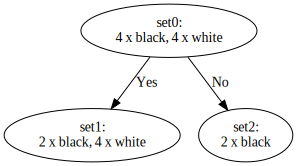

In [13]:
g = graphviz.Digraph(format='svg', graph_attr={'rankdir': 'TD'})
g.node('O', 'set0: \n4 x black, 4 x white')
g.node('L', 'set1: \n2 x black, 4 x white')
g.node('R', 'set2: \n2 x black')

g.edge('O', 'L', label='Yes' )
g.edge('O', 'R', label='No' )
g

In [48]:
set0 = ['black']*4 + ['white']*4
set1 = ['black']*2 + ['white']*4
set2 = ['black']*2
# weighted average Gini index
weighted_average_gini = (gini(set1) * len(set1) + gini(set2)*len(set2)) / len(set0)

print(f"Gini index for set1={gini(set1)}, for set2={gini(set2)}")
print("weighted average Gini index: ", weighted_average_gini)

# weighted average Entropy:
weighted_average_entropy = (entropy(set1) * len(set1) + entropy(set2) * len(set2))/len(set0)

print(f"Entropy for set1={entropy(set1)}, for set2={entropy(set2)}")
print("weighted average Entropy: ", weighted_average_entropy)

Gini index for set1=0.4444444444444444, for set2=0.0
weighted average Gini index:  0.3333333333333333
Entropy for set1=0.9182958340544896, for set2=0.0
weighted average Entropy:  0.6887218755408672


## hyperparameters

One hyperparameter for building the decision tree is when to stop, because the more we split the dataset and add to the tree nodes, the smaller the sample size for each node, which can cause overfitting. Some thresholds for this hyperparam can be:
1. if the change in **accuracy, Gini index, Entropy** < some threshold
2. don't split a node if its **sample size** < some threshold
3. split a node only if resulting **child nodes sample sizes** > some threshold
4. stop building the tree if its **depth** > some threshold

The way to choose the hyperparam is either by experience or by running exhaustive search based on performance on validation set - this is called *grid search*.

## Decision Tree algorithm
Basically building the tree (by splitting the node/samples until stopping condition is met by all leaf nodes.

**Gini gain**: is the difference between weighted-average Gini index of leave nodes and the Gini index of their parent node. (parent - children)

**Information gain**: is the difference between the weighted-averaged Entropy of leave nodes and the Entropy of their parent node. (parent - children)

In the above example of set1, set2:

In [16]:
p_black0 = 4/8
p_white0 = 4/8
gini_set0 = 1- (4/8)**2 - (4/8)**2
p_set0 = [p_black1, p_white1]
gini_set0 = [-p**2 for p in p_set0]
gini_set0 = 1 + sum(gini_set0)
entropy_set0 = sum([-p * math.log2(p) for p in p_set0])

gini_gain = gini_set0-weighted_average_gini
info_gain = entropy_set0-weighted_average_entropy

print(f"set0 Gini index={gini_set0}, Gini gain={gini_gain}")
print(f"set0 Entropy={entropy_set0}, Information gain={info_gain}")

set0 Gini index=0.4444444444444444, Gini gain=0.1111111111111111
set0 Entropy=0.9182958340544896, Information gain=0.2295739585136224


In [52]:
# to determine different ways of splitting the list and the best option
elements = ['A', 'A', 'A', 'C', 'B', 'C']
ginis = np.zeros(len(elements))
for i in range(len(elements)):
  left = elements[:i]
  right = elements[i:]
  weighted_average_gini = (gini(left) * len(left) + gini(right)*len(right))/len(elements)
  weighted_average_entropy = (entropy(left)*len(left) + entropy(right)*len(right)) / len(elements)

  print(f"{left}, {right}")
  print(f"weighted average Gini Impurity Index: {weighted_average_gini}")
  print(f"weighted average Entropy            : {weighted_average_entropy}")
  print("")

  ginis[i] = weighted_average_gini

idx = ginis.argmin()
print(f"best split: {elements[:idx]}, {elements[idx:]}")

[], ['A', 'A', 'A', 'C', 'B', 'C']
weighted average Gini Impurity Index: 0.6111111111111112
weighted average Entropy            : 1.4591479170272448

['A'], ['A', 'A', 'C', 'B', 'C']
weighted average Gini Impurity Index: 0.5333333333333332
weighted average Entropy            : 1.268273412406135

['A', 'A'], ['A', 'C', 'B', 'C']
weighted average Gini Impurity Index: 0.4166666666666667
weighted average Entropy            : 1.0

['A', 'A', 'A'], ['C', 'B', 'C']
weighted average Gini Impurity Index: 0.2222222222222222
weighted average Entropy            : 0.4591479170272448

['A', 'A', 'A', 'C'], ['B', 'C']
weighted average Gini Impurity Index: 0.4166666666666667
weighted average Entropy            : 0.8741854163060886

['A', 'A', 'A', 'C', 'B'], ['C']
weighted average Gini Impurity Index: 0.4666666666666666
weighted average Entropy            : 1.142458828712224

best split: ['A', 'A', 'A'], ['C', 'B', 'C']


## beyond binary splitting
### one-hot encoding
When dealing with multiple classes of a feature (e.g. which animal), we turn the question into binary features (is it a dog, is it a cat, etc.). To figure out which questions to ask first, we use the above methods (accuray, Gini index, Entropy). This process of turning non-binary catagorical feature into several binary features is called *one-hot encoding*.

### Splitting data using continuous features
such as age. We turn them into bands of values/thresholds. To choose which thresholds to use, we again use weighted accuracy/Gini index/Entropy (to maximise accuracy, minimise Gini index and Entropy).

## Graphical boundary of Decision Trees

In [83]:
dataset = pd.DataFrame({
  'x_0':[7,3,2,1,2,4,1,8,6,7,8,9],
  'x_1':[1,2,3,5,6,7,9,10,5,8,4,6],
  'y': [0,0,0,0,0,0,1,1,1,1,1,1]
})
features = dataset[['x_0', 'x_1']]
labels = dataset['y']

# plt.scatter(features['x_0'][:6], features['x_1'][:6], color='red', edgecolor='k', marker='s')
# plt.scatter(features['x_0'][6:], features['x_1'][6:], color='cyan', edgecolor='k', marker='^')
# plt.legend(['y=0', 'y=1'])


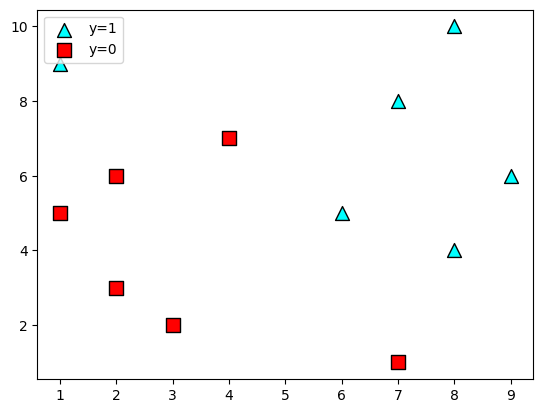

In [84]:
plot_points(features, labels)
plt.legend(['y=1', 'y=0'])

model score:  1.0


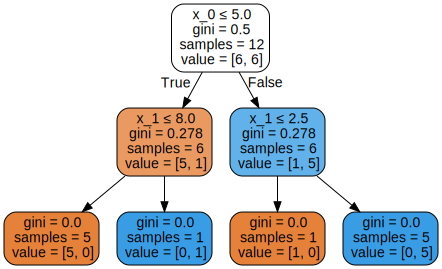

In [213]:
model = DecisionTreeClassifier() # default is using Gini
# model = DecisionTreeClassifier(criterion='entropy')

model.fit(features, labels)
print("model score: ", model.score(features, labels))

dot_data = export_graphviz(model, feature_names=['x_0', 'x_1'],
                           filled=True, rounded=True, special_characters=True)
g = graphviz.Source(dot_data)
g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


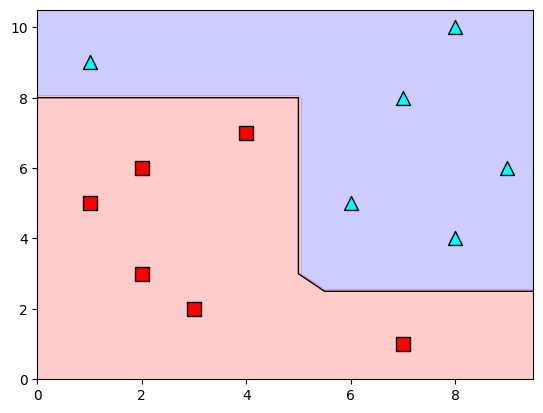

In [197]:
# plot_model(features, labels, model)
plot_step = .5
X = np.array(features)
y = np.array(labels)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) # ravel is similar to flatten() it's a view
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=[float('-inf'), 0.1, float('inf')])
plt.contour(xx, yy, Z,colors = 'k',linewidths = 1, levels=0)
plot_points(X, y)
plt.show()

The above contour plot matches the tree diagram:
* vertical line is x_0=5
* top horizonal line is x_1=8
* bottom horizontal line is x_1=2.5

In [208]:
model.predict([[5.5,2.5]])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([0])

In [126]:
Z, Z.shape

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 (11, 10))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


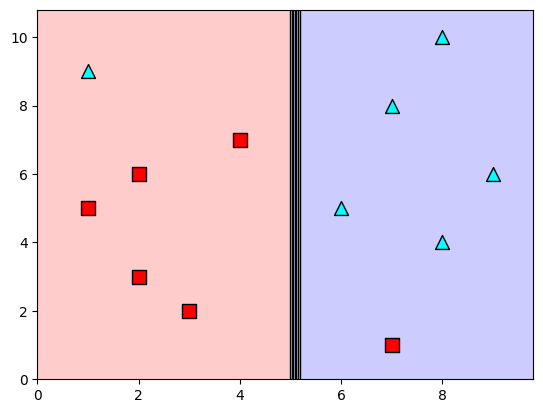

In [210]:
# building decision tree of depth 1
decision_tree_depth_1 = DecisionTreeClassifier(max_depth=1)
decision_tree_depth_1.fit(features, labels)
decision_tree_depth_1.score(features, labels)
plot_model(features, labels, decision_tree_depth_1)

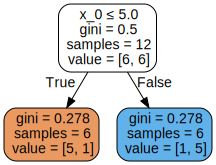

In [212]:
dot_data = export_graphviz(decision_tree_depth_1, feature_names=['x_0', 'x_1'],
                           filled=True, rounded=True, special_characters=True)
g = graphviz.Source(dot_data)
g

## Example - model student admin

dataset features:
* GRE score: a number out of 340
* TOFEL score: a number out of 120
* Uni rating: a number from 1 to 5
* SOP: a number from 1 to 5
* CGPA: a number from 1 to 10
* LOR: a number from 1 to 5
* Research experience: boolean (0 or 1)

In [214]:
!rm -f data/Admission_Predict.csv
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_09_Decision_Trees/Admission_Predict.csv
!ls -al data
!wc -l data/Admission_Predict.csv

2025-02-26 04:44:06 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_09_Decision_Trees/Admission_Predict.csv [12501/12501] -> "data/Admission_Predict.csv" [1]
total 24
drwxr-xr-x 2 root root  4096 Feb 26 04:44 .
drwxr-xr-x 1 root root  4096 Feb 26 04:44 ..
-rw-r--r-- 1 root root 12501 Feb 26 04:44 Admission_Predict.csv
400 data/Admission_Predict.csv


In [217]:
data = pd.read_csv('data/Admission_Predict.csv')
# replace a column
data['Admitted'] = data['Chance of Admit'] >= 0.75
data = data.drop(['Chance of Admit'], axis=1)
data

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admitted
0,1,337,118,4,4.5,4.5,9.65,1,True
1,2,324,107,4,4.0,4.5,8.87,1,True
2,3,316,104,3,3.0,3.5,8.00,1,False
3,4,322,110,3,3.5,2.5,8.67,1,True
4,5,314,103,2,2.0,3.0,8.21,0,False
...,...,...,...,...,...,...,...,...,...
395,396,324,110,3,3.5,3.5,9.04,1,True
396,397,325,107,3,3.0,3.5,9.11,1,True
397,398,330,116,4,5.0,4.5,9.45,1,True
398,399,312,103,3,3.5,4.0,8.78,0,False


In [233]:
features = data.drop(['Admitted', 'Serial No.'], axis=1)
labels = data['Admitted']
features, labels

(     GRE Score  TOEFL Score  University Rating  SOP  LOR  CGPA  Research
 0          337          118                  4  4.5  4.5  9.65         1
 1          324          107                  4  4.0  4.5  8.87         1
 2          316          104                  3  3.0  3.5  8.00         1
 3          322          110                  3  3.5  2.5  8.67         1
 4          314          103                  2  2.0  3.0  8.21         0
 ..         ...          ...                ...  ...  ...   ...       ...
 395        324          110                  3  3.5  3.5  9.04         1
 396        325          107                  3  3.0  3.5  9.11         1
 397        330          116                  4  5.0  4.5  9.45         1
 398        312          103                  3  3.5  4.0  8.78         0
 399        333          117                  4  5.0  4.0  9.66         1
 
 [400 rows x 7 columns],
 0       True
 1       True
 2      False
 3       True
 4      False
        ...  
 

In [237]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(features, labels)
print("score: ", model.score(features, labels))
print("depth: ", model.get_depth())
print(model.predict(features[0:5]))

score:  1.0
depth:  10
[ True  True False  True False]


The score is 100% in the training set. This is massively overfit.

In [235]:
features.columns.tolist()

['GRE Score',
 'TOEFL Score',
 'University Rating',
 'SOP',
 'LOR',
 'CGPA',
 'Research']

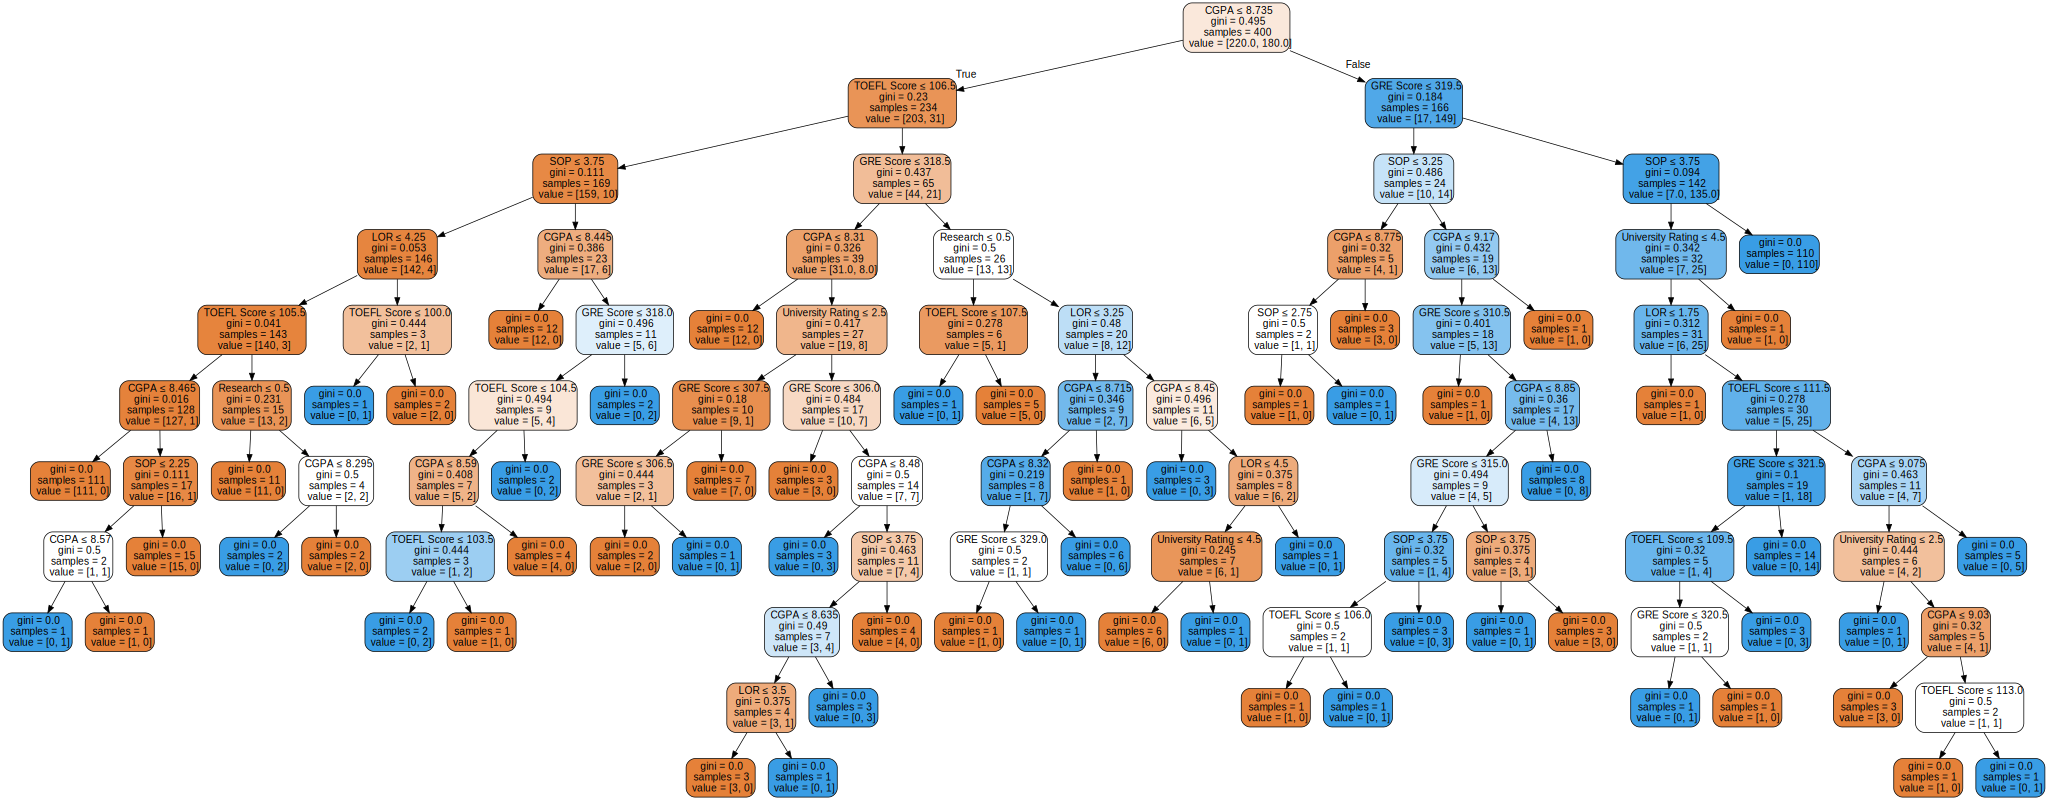

In [236]:
dot_data = export_graphviz(model, feature_names=features.columns.tolist(),
                           filled=True, rounded=True, special_characters=True)
g = graphviz.Source(dot_data)
g

In [239]:
# to prevent overfitting, we can play with some hyperparam
model_smaller = DecisionTreeClassifier(max_depth=5,
                                       min_samples_leaf = 10,
                                       min_samples_split = 10)
model_smaller.fit(features, labels)
print("score: ", model_smaller.score(features, labels))
print("depth: ", model_smaller.get_depth())
print(model_smaller.predict(features[0:5]))

score:  0.8975
depth:  5
[ True  True False  True False]


In [240]:
model_smaller.predict([[320, 110, 3, 4.0, 3.5, 8.9, 0]])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([ True])

The construction of the tree is greedy in nature - at each point it selects the top feature. This does not work well for example, if a combo of features is strong, but none of the individual features are string.

## Decision Trees for regression